# Burgers' equation
As a nonlinear test case, let us consider the data from Burgers' equation given by

$    \frac{\partial f}{\partial t} + \frac{\partial (A f^2)}{\partial x} = 0 $

where $A = -1$. The data is obtained with similar simulation setup as for heat equation except for the time step, i.e. $\Delta t = 0.01 \Delta x/(1+|A|)$.

First, load the needed libraries:

In [14]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from adjoint import *
size = 6
cm = 0.393701

## Generate Data

(1, 100)
(1, 100)
(1, 1000, 100)


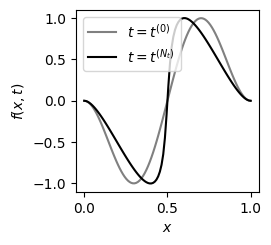

In [15]:
## generate data
# df/dt + A*f*df/dx = 0

CFL = 0.01
def dt_cfl(dx, A_m):
    # dt of simulation should be set satisfying CFL condition for stability
    return CFL*dx/(1.+abs(A_m)) #CFL*min(dx/abs(A_m+1e-15),dx**2/abs(D_m+1e-15))
    
def burger_equation(A_m, f0_m, dx_m, dt_m, Nt_m):
    f_m = np.zeros((Nt_m, len(f0_m)))
    f_m[0,:] = f0_m
    for i in range(Nt_m-1):
        f_m[i+1,:] = f_m[i,:] - np.gradient( A_m*f_m[i,:]**2)/dx_m * dt_m
    return f_m

L = 1.0  # Length of the domain
Nx = 100  # Number of spatial grid points
A_ex = -1.0  # Advection coefficient

dx = L/Nx
dt = dt_cfl(dx, A_ex)
Nt = 1000
T = dt*Nt

# Initial condition
x =  np.linspace(0, L, Nx)
f0 = 5.*np.sin(2.* np.pi * x)*x*(x-L)
fs = burger_equation(A_ex, f0, dx, dt, Nt)

dx = np.array([dx])
x = np.array([x])
f0 = np.array([f0])
fs = np.array([fs])

fs0 = fs.copy()

print(x.shape)
print(f0.shape)
print(fs.shape)

fig = plt.figure(figsize=(size*cm, size*cm))
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x,t)$')
plt.plot(x[0],fs[0,0,:], color="grey", label=r"$t=t^{(0)}$")
plt.plot(x[0],fs[0,-1,:], color="black", label=r"$t=t^{(N_t)}$")
plt.legend()

plt.savefig("data_BurgersEq_t0tf"+".pdf",format='pdf', bbox_inches="tight", dpi=300)

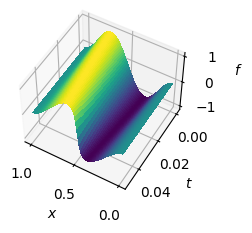

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ts = np.array([[i*dt for i in range(Nt)]])

X, T = np.meshgrid(x[0], ts[0])
fig = plt.figure(figsize=(size*cm, size*cm))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, fs[0,:,:], rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.view_init(elev=50, azim=120)
ax.zaxis.set_rotate_label(False)
ax.set_zlim([-1.1,1.1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.set_zlabel(r'$f$', rotation = 0)
plt.savefig("data_BurgersEq"+".pdf",format='pdf', dpi=300, bbox_inches="tight")

## Find pde using the adjoint method

In [18]:
ds = np.array([[1], [2], [3]])
ps = np.array([[1], [2], [3]])

start_time = time.time()
estimated_params, eps, losses = AdjointFindPDE(fs, x, dx, data_dt=dt, avg=False, gamma=1e-3, epochs=60, epthr=60, beta = 0.0001, ds=ds, ps=ps, V = L, tol = 1e-15, eps0=1e-16)
end_time = time.time()
print("Execution time: "+str(end_time-start_time))

Execution time: 88.643967628479


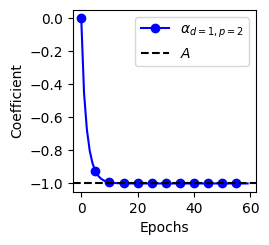

total number of terms: 9
6.88338275267597e-14


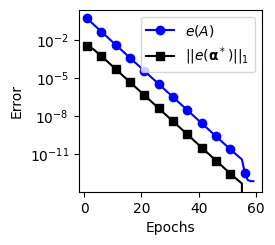

In [19]:
problem = "1D_burgers_eq"
i_pde = 0

plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if ( d[0]==1 and p[0]==2 ):
            plt.plot(estimated_params[:,i_pde,id,ip], label=r"$α_{d="+str(d[0])+", p="+str(p[0])+"}$", color="blue",marker="o", markevery=5)
            total_error = estimated_params[-1,i_pde,id,ip]
total_error = abs(total_error-A_ex)
plt.axhline(A_ex, color="black", linestyle = "--", label=r"$A$")
plt.ylabel('Coefficient')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "Aconv"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)
plt.show()

err_other = np.zeros_like(estimated_params[:,0,0,0])
count = 0
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if not ( d[0]==1 and p[0]==2 ):
            err_other += abs(estimated_params[:,i_pde,id,ip])
            count += 1

i_pde = 0
plt.figure(figsize=(size*cm, size*cm))
for id, d in enumerate(ds):
    for ip, p in enumerate(ps):
        if d[0]==1 and p[0]==2:
            plt.plot(eps[1:], abs(estimated_params[1:,i_pde,id,ip]-A_ex),
                     label=r"$e(A)$", marker="o", markevery=5, color="blue")
plt.plot(eps[1:], err_other[1:]/count, marker="s", markevery=5, color="black", label=r"$||e(\mathbf{\alpha}^*)||_1$")
plt.yscale('log')
plt.ylabel(r'Error')
plt.xlabel('Epochs')
plt.legend()
name = problem + "_" + "A"
#plt.savefig(name+".pdf",format='pdf', bbox_inches="tight", dpi=300)

print("total number of terms: "+str(1*len(ds)*len(ps)))

total_error += err_other[-1]
print(total_error)
